### Machine Learning for AES
We will be experimenting with different machine learning based models for essay scoring. They will be trained on style and content based features. The goal is to improve the mean quadratic kappa score. 

In [1]:
#Utils
import re
import pprint
import itertools
import numpy as np
from numpy.linalg import svd
import pandas as pd
from time import time 
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt

#NLP
import nltk
from nltk.corpus import stopwords
import language_check
from spellchecker import SpellChecker
from nltk.tag.perceptron import PerceptronTagger
from gensim.models import word2vec
from nltk.stem.porter import PorterStemmer

#ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.spatial.distance import cosine
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

%matplotlib inline

unable to import 'smart_open.gcs', disabling that module


### Dataset Loading
We will first load the essays from the csv filed provided in the asap data set. These essays will then be divided based on their set no and stored in separate data frames. We will also load the prompt text that is divided in to 4 paragraphs for the source dependent essays. This will be used to generate similarity scores for the essays. 

In [2]:
def split_in_sets(data):
    essay_sets = []
    min_scores = []
    max_scores = []
    for s in range(1,9):
        essay_set = data[data["essay_set"] == s]
        essay_set.dropna(axis=1, inplace=True)
        n, d = essay_set.shape
        set_scores = essay_set["domain1_score"]
        print ("Set", s, ": Essays = ", n , "\t Attributes = ", d)
        min_scores.append(set_scores.min())
        max_scores.append(set_scores.max())
        essay_sets.append(essay_set)
    return (essay_sets, min_scores, max_scores)

In [3]:
dataset_path = "./asap-aes/training_set_rel3.tsv"
data = pd.read_csv(dataset_path, sep="\t", encoding="ISO-8859-1", index_col="essay_id")

min_scores = [2, 1, 0, 0, 0, 0, 0, 0]
max_scores = [12, 6, 3, 3, 4, 4, 30, 60]

essay_sets, data_min_scores, data_max_scores = split_in_sets(data)
set1, set2, set3, set4, set5, set6, set7, set8 = tuple(essay_sets)
data.dropna(axis=1, inplace=True)

data.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
print("All Data:", len(data))
data.head()

Set 1 : Essays =  1783 	 Attributes =  5
Set 2 : Essays =  1800 	 Attributes =  8
Set 3 : Essays =  1726 	 Attributes =  5
Set 4 : Essays =  1770 	 Attributes =  5
Set 5 : Essays =  1805 	 Attributes =  5
Set 6 : Essays =  1800 	 Attributes =  5
Set 7 : Essays =  1569 	 Attributes =  13
Set 8 : Essays =  723 	 Attributes =  17
All Data: 12976


,essay_set,essay,domain1_score
essay_id,,,
1,1,"Dear local newspaper, I think effects computer...",8
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
5,1,"Dear @LOCATION1, I know having computers has a...",8


In [4]:
# Read prompt text
set_3_prompt = open("./prompts/set3.txt").read()
set_3_prompt = set_3_prompt.splitlines()

set_4_prompt = open("./prompts/set4.txt").read()
set_4_prompt = set_4_prompt.splitlines()

set_5_prompt = open("./prompts/set5.txt").read()
set_5_prompt = set_5_prompt.splitlines()

set_6_prompt = open("./prompts/set6.txt").read()
set_6_prompt = set_6_prompt.splitlines()

set_prompts = [set_3_prompt, set_4_prompt, set_5_prompt, set_6_prompt]

### Key Definition
We will be defining the keys for columns names here.

In [5]:
#Dataset keys
essay_id_key = "essay_id"
essay_set_key = "essay_set"
essay_key = "essay"
domain1_score_key = "domain1_score"

#Feature keys
feature_keys = {
    "char_count_key": "char_count",
    "word_count_key": "word_count",
    "diff_words_count_key": "diff_words_count",
    "word_count_root_key": "word_count_root",
    "sen_count_key": "sen_count",
    "avg_word_len_key": "avg_word_len",
    "avg_sen_len_key": "avg_sen_len",
    "l5_word_count_key": "l5_word_count",
    "l6_word_count_key": "l6_word_count",
    "l7_word_count_key": "l7_word_count",
    "l8_word_count_key": "l8_word_count",
}

#Extra features
extra_feature_keys = {
    "spelling_error_count_key": "spelling_error_count",
    "stopwords_count_key": "stopwords_count",
    "small_sentences_count_key": "small_sentence_count", #sentences less than len 4
    "punctuations_count_key": "punctuations_count",
    "verbs_count_key": "verbs_count",
    "adverbs_count_key": "adverbs_count",
    "nouns_count_key": "nouns_count",
    "adjectives_count_key": "adjective_count",
}

sentences_key = "sentences"
word_count_vector_key = "word_count_vector"
feature_keys["sentenc_key"] = sentences_key
feature_keys["word_count_vector_key"] = word_count_vector_key

similarity_labels = ["para_1_sim", "para_2_sim", "para_3_sim", "para_4_sim", "whole_prompt_sim"]
worvec_similarity_labels = ["wv_para_1_sim", "wv_para_2_sim", "wv_para_3_sim", "wv_para_4_sim", "wv_whole_prompt_sim"]

In [6]:
feature_keys_list = list(feature_keys.values())
extra_feature_keys_list = list(extra_feature_keys.values())
all_feature_keys_list = feature_keys_list + extra_feature_keys_list

print("Basic 11 features: ", feature_keys_list, "\n")
print("Extra features: ", extra_feature_keys_list, "\n")
print("All features: ", all_feature_keys_list, "\n")

Basic 11 features:  ['char_count', 'word_count', 'diff_words_count', 'word_count_root', 'sen_count', 'avg_word_len', 'avg_sen_len', 'l5_word_count', 'l6_word_count', 'l7_word_count', 'l8_word_count', 'sentences', 'word_count_vector'] 

Extra features:  ['spelling_error_count', 'stopwords_count', 'small_sentence_count', 'punctuations_count', 'verbs_count', 'adverbs_count', 'nouns_count', 'adjective_count'] 

All features:  ['char_count', 'word_count', 'diff_words_count', 'word_count_root', 'sen_count', 'avg_word_len', 'avg_sen_len', 'l5_word_count', 'l6_word_count', 'l7_word_count', 'l8_word_count', 'sentences', 'word_count_vector', 'spelling_error_count', 'stopwords_count', 'small_sentence_count', 'punctuations_count', 'verbs_count', 'adverbs_count', 'nouns_count', 'adjective_count'] 



### Feature Generation
We will now generate different style and content based features. The functions ahead will be used to process the words in essays and generate various features from them.

In [7]:
tagger=PerceptronTagger()
tool = language_check.LanguageTool('en-US')
spell = SpellChecker()
spell.word_frequency.load_words(["PERSON", "ORGANIZATION", "LOCATION", "DATE", "TIME", "MONEY", "PERCENT", "CAPS"])
stemmer = PorterStemmer()
max_idx = [0, 0, 0, 0]
word_to_idx = [{}, {}, {}, {}]
idx_to_word = [{}, {}, {}, {}]

# Process words of essays
def sentence_to_word_list(sentence, remove_stopwords, set_no):
    global max_idx
    global word_to_idx
    global idx_to_word
            
    sen_char_count = 0
    sen_word_count = 0
    l5_sen_word_count = 0
    l6_sen_word_count = 0
    l7_sen_word_count = 0
    l8_sen_word_count = 0    
    sen_diff_words = set()
    ### Extra Features ###
    sen_verbs_count = 0
    sen_adverbs_count = 0
    sen_nouns_count = 0
    sen_adjectives_count = 0
    sen_spelling_error_count = 0
    sen_stopwords_count = 0
    is_small_sentence = 0

    stops = set(stopwords.words("english"))
    all_words = sentence.lower().split()


    kept_words = []

    if len(all_words) <= 4: is_small_sentence = 1

    misspelled = spell.unknown(all_words)
    sen_spelling_error_count = len(misspelled)
    
    for word in all_words:
        
        sen_char_count += len(word)
        sen_word_count += 1
        word_len = len(word)
        if word_len > 5:
            l5_sen_word_count += 1
        if word_len > 6:
            l6_sen_word_count += 1
        if word_len > 7:
            l7_sen_word_count += 1
        if word_len > 8:
            l8_sen_word_count += 1

        sen_diff_words.add(word)
        kept_words.append(word)
        
        isStopword = word in stops
        process_word = (remove_stopwords and not isStopword) or (not remove_stopwords) 
        if process_word:
            set_idx = set_no - 3
            if set_idx >= 0 and set_idx <= 3:
                stem_word = stemmer.stem(word)
                if not stem_word in word_to_idx[set_idx]:    
                    word_to_idx[set_idx][stem_word] = max_idx[set_idx]
                    idx_to_word[set_idx][max_idx[set_idx]] = stem_word
                    max_idx[set_idx] += 1

        if isStopword: sen_stopwords_count += 1

    features = {
         feature_keys["char_count_key"]: sen_char_count,
         feature_keys["word_count_key"]: sen_word_count,
         feature_keys["l5_word_count_key"]: l5_sen_word_count,
         feature_keys["l6_word_count_key"]: l6_sen_word_count,
         feature_keys["l7_word_count_key"]: l7_sen_word_count,
         feature_keys["l8_word_count_key"]: l8_sen_word_count,
         feature_keys["diff_words_count_key"]: sen_diff_words
    }

    extra_features = {
        extra_feature_keys["small_sentences_count_key"]: is_small_sentence,
        extra_feature_keys["spelling_error_count_key"]: sen_spelling_error_count,
        extra_feature_keys["stopwords_count_key"]: sen_stopwords_count,
        extra_feature_keys["verbs_count_key"]: sen_verbs_count,
        extra_feature_keys["adverbs_count_key"]: sen_adverbs_count,
        extra_feature_keys["nouns_count_key"]: sen_nouns_count,
        extra_feature_keys["adjectives_count_key"]: sen_adjectives_count,
    }

    return (kept_words, features, extra_features)


# Process sentences of essays
def essay_to_sentences(essay, set_no, remove_stopwords = False):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    sentences = tokenizer.tokenize(essay.strip())
    split_sentences = []
    split_words = []
    
    char_count = 0
    word_count = 0
    diff_words = set()
    word_count_root = 0
    sen_count = 0
    avg_word_len = 0
    avg_sen_len = 0
    l5_word_count = 0
    l6_word_count = 0
    l7_word_count = 0
    l8_word_count = 0    
    ### Extra Features ###
    spelling_error_count = 0
    stopwords_count = 0
    small_sentences_count = 0
    punctuation_count = 0
    grammer_error_count = 0
    small_sentences_count = 0
    verbs_count = 0
    adverbs_count = 0
    nouns_count = 0
    adjectives_count = 0
 
    all_words = nltk.word_tokenize(essay)
    count= Counter([j for i,j in tagger.tag(all_words)])
    verbs_count = count['VB'] + count['VBG'] + count['VBP'] + count['VBN'] + count['VBZ']
    adverbs_count = count['RB'] + count['RBR'] + count['RBS']
    nouns_count = count['NN'] + count['NNS'] + count['NNPS'] + count['NNP']
    adjectives_count = count['JJ'] + count['JJR'] 

    punctuation = ['.','?', '!', ':', ';']
    for punct in punctuation:
        punctuation_count += essay.count(punct)
    
    for sentence in sentences:
        if len(sentence) > 0:
            sentence = re.sub("[^a-zA-Z]", " ", sentence)
            kept_words, features, extra_features = sentence_to_word_list(sentence, remove_stopwords, set_no)
            split_sentences.append(kept_words)
            split_words.extend(kept_words)
            
            sen_count +=1
            char_count += features[feature_keys["char_count_key"]]
            word_count += features[feature_keys["word_count_key"]]
            l5_word_count += features[feature_keys["l5_word_count_key"]]
            l6_word_count += features[feature_keys["l6_word_count_key"]]
            l7_word_count += features[feature_keys["l7_word_count_key"]]
            l8_word_count += features[feature_keys["l8_word_count_key"]]
            diff_words = diff_words|features[feature_keys["diff_words_count_key"]]
            ### Extra Features ###
            spelling_error_count += extra_features[extra_feature_keys["spelling_error_count_key"]]
            stopwords_count += extra_features[extra_feature_keys["stopwords_count_key"]]
            small_sentences_count += extra_features[extra_feature_keys["small_sentences_count_key"]]
          
    word_count_root = word_count ** (1/4)
    avg_word_len = char_count / word_count
    avg_sen_len = word_count / sen_count
    
    features = {
        feature_keys["char_count_key"]: char_count,
        feature_keys["word_count_key"]: word_count,
        feature_keys["diff_words_count_key"]: len(diff_words),
        feature_keys["word_count_root_key"]: word_count_root,
        feature_keys["sen_count_key"]: sen_count,
        feature_keys["avg_word_len_key"]: avg_word_len,
        feature_keys["avg_sen_len_key"]: avg_sen_len,
        feature_keys["l5_word_count_key"]: l5_word_count,
        feature_keys["l6_word_count_key"]: l6_word_count,
        feature_keys["l7_word_count_key"]: l7_word_count,
        feature_keys["l8_word_count_key"]: l8_word_count
    }

    extra_features = {
        extra_feature_keys["spelling_error_count_key"]: spelling_error_count,
        extra_feature_keys["stopwords_count_key"]: stopwords_count,
        extra_feature_keys["small_sentences_count_key"]: small_sentences_count,
        extra_feature_keys["punctuations_count_key"]: punctuation_count,
        extra_feature_keys["verbs_count_key"]: verbs_count,
        extra_feature_keys["adverbs_count_key"]: adverbs_count,
        extra_feature_keys["nouns_count_key"]: nouns_count,
        extra_feature_keys["adjectives_count_key"]: adjectives_count 
    }

    return (split_words, split_sentences, features, extra_features)

# Generate the average word vector representation of a word list
def get_avg_word_vec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords += 1.
            featureVec = np.add(featureVec, model[word])        
    featureVec = np.divide(featureVec, nwords)
    return featureVec

# Generate the word vector representation for paragraphs from essay prompt
def get_prompt_word_vecs(prompt, model, num_features):
    whole_prompt_words = []
    vectors = []
    for para in prompt:
        tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        sentences = tokenizer.tokenize(para.strip())
        para_words = []
        for sentence in sentences:
            if len(sentence) > 0:
                sentence = re.sub("[^a-zA-Z]", " ", sentence)
                words = sentence.lower().split()
                para_words.extend(words)
                whole_prompt_words.extend(words)
        vectors.append(get_avg_word_vec(para_words, model, num_features))
    vectors.append(get_avg_word_vec(whole_prompt_words, model, num_features))
    return vectors

# Generate the word count vector for a word list
def get_word_count_vector(words, set_no):
    set_idx = set_no - 3
    if set_idx >= 0 and set_idx <= 3: 
        word_count_vector = np.zeros((max_idx[set_idx]+1,))
        for word in words:
            word = stemmer.stem(word)
            if word in word_to_idx[set_idx]:
                word_count_vector[word_to_idx[set_idx][word]] += 1
        return word_count_vector
    
# Generate the word count vector for paragraphs of essay prompts
def get_prompt_vectors(prompt, set_no):
    whole_prompt_words = []
    vectors = []
    for para in prompt:
        tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        sentences = tokenizer.tokenize(para.strip())
        para_words = []
        for sentence in sentences:
            if len(sentence) > 0:
                sentence = re.sub("[^a-zA-Z]", " ", sentence)
                words = sentence.lower().split()
                para_words.extend(words)
                whole_prompt_words.extend(words)
        vectors.append(get_word_count_vector(para_words, set_no))
    vectors.append(get_word_count_vector(whole_prompt_words, set_no))
    return vectors

### Feature Generation Example
Here is an example of features generated for the first essay from the dataset.

In [8]:
pp = pprint.PrettyPrinter(indent=4)

#Featrues
first_essay = data.iloc[0][essay_key]
print(first_essay)
start = time()
_, _, features, extra_features = essay_to_sentences(first_essay, set_no = 1)
end = time()

print("\nExecution time:", end-start)

print("\n\nFeatures: ")
pp.pprint(features)

print("\n\n Extra Features: ")
pp.pprint(extra_features)



Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question about the economy

### Generation of Learning Data
We will now process the essays one by one and generate the style based features for them. We will also be generating word count vector based similarities with the prompt for the source dependent essays. The dimansionality of these word count vectors is reduced using LSA.

In [9]:
prompt_vectors = []

def makeDataFrame(data):
    global prompt_vectors
    all_features = {}
    all_scores = {}
    essay_words = []
    log_frequency = 3000

    print("Generating Style Features")
    for row in range(len(data)):
        if (row+1) % log_frequency == 0 and row != 0: print("Processed ", (row+1), " essays of", len(data))
        essay_data = data.iloc[row]
        essay = essay_data[essay_key]
        essay_id = essay_data.name
        set_no = essay_data[essay_set_key]
        essay_score = essay_data[domain1_score_key]
        words, _, features, extra_features = essay_to_sentences(essay, set_no=set_no)
        essay_words.append(words)
        combined_features = {}
        combined_features.update(features)
        combined_features.update(extra_features)
        combined_features[sentences_key] = words
        all_features[essay_id] = combined_features
        all_scores[essay_id] = essay_score
        
    for set_idx, set_prompt in enumerate(set_prompts):
        set_no = set_idx + 3
        vectors = get_prompt_vectors(set_prompt, set_no)
        prompt_vectors.append(vectors)
    
    print("Generating Similarity Measures")
    for row in range(len(data)):
        if (row+1) % log_frequency == 0 and row != 0: print("Processed ", (row+1), " essays of", len(data))
        essay_data = data.iloc[row]
        essay_id = essay_data.name
        set_no = essay_data[essay_set_key]
        set_idx = set_no - 3

        if (0 > set_idx or 3 < set_idx):
            continue
        else: 
            essay_vector = get_word_count_vector(essay_words[row], set_no)
            all_features[essay_id][word_count_vector_key] = essay_vector
            prompt_vecs = prompt_vectors[set_idx]
            prompt_vecs = np.stack(prompt_vecs, axis=0)
            all_vecs = np.vstack([prompt_vecs, essay_vector])
            
            tfd = TruncatedSVD(6, random_state=1)
            all_vecs = tfd.fit_transform(all_vecs)
            
            for i in range(len(prompt_vecs)):
                sim = 1 - cosine(all_vecs[i], all_vecs[all_vecs.shape[0]-1])
                all_features[essay_id][similarity_labels[i]] = sim    
        
    X = pd.DataFrame.from_dict(all_features, orient="index")
    y = pd.DataFrame.from_dict(all_scores, orient="index")

    return(X, y)



In [10]:
start = time()
X, y = makeDataFrame(data)
end = time()
X_basic = X[feature_keys_list]

print("\nExecution time to make dataframe ", (end-start)/60, " mins\n")

print("All Features:\n")
display(X.head(1))

print("Basic 11 Features:\n")
display(X_basic.head(1))

Generating Style Features
Processed  3000  essays of 12976
Processed  6000  essays of 12976
Processed  9000  essays of 12976
Processed  12000  essays of 12976
Generating Similarity Measures
Processed  3000  essays of 12976
Processed  6000  essays of 12976
Processed  9000  essays of 12976
Processed  12000  essays of 12976

Execution time to make dataframe  5.070565915107727  mins

All Features:



,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
1,1478,350,164,4.325308,16,4.222857,21.875,74,59,34,...,21,84,22,"[dear, local, newspaper, i, think, effects, co...",NaN,NaN,NaN,NaN,NaN,NaN


Basic 11 Features:



,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,l8_word_count,sentences,word_count_vector
1,1478,350,164,4.325308,16,4.222857,21.875,74,59,34,13,"[dear, local, newspaper, i, think, effects, co...",NaN


### Splitting by set number
The main dataframe will be split based on the set number of the essay.

In [11]:
X_sets = []
y_sets = []
essay_sets = [set1, set2, set3, set4, set5, set6, set7, set8]
for set_no in range(8):
    # X_set, y_set = makeDataFrame(essay_sets[set_no])
    X_set, y_set = X.loc[X.index & essay_sets[set_no].index], y.loc[y.index & essay_sets[set_no].index]
    X_sets.append(X_set)
    y_sets.append(y_set) 

    print("Set", (set_no+1), ":", len(X_set), " essays")   
    display(X_set.head(1))

Set 1 : 1783  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
1,1478,350,164,4.325308,16,4.222857,21.875,74,59,34,...,21,84,22,"[dear, local, newspaper, i, think, effects, co...",NaN,NaN,NaN,NaN,NaN,NaN


Set 2 : 1800  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
2978,2064,486,194,4.695254,19,4.246914,25.578947,114,57,32,...,36,130,30,"[certain, materials, being, removed, from, lib...",NaN,NaN,NaN,NaN,NaN,NaN


Set 3 : 1726  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
5978,209,51,31,2.672345,3,4.098039,17.0,13,10,4,...,0,15,1,"[the, features, of, the, setting, affect, the,...","[8.0, 2.0, 4.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, ...",0.607915,0.547689,0.497195,0.425263,0.591386


Set 4 : 1770  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
8863,243,58,44,2.759669,3,4.189655,19.333333,16,8,4,...,4,10,3,"[the, author, concludes, the, story, with, thi...","[4.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, ...",0.385886,0.430285,0.474141,0.473287,0.496734


Set 5 : 1805  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
11827,570,131,80,3.383123,8,4.351145,16.375,36,21,9,...,3,37,5,"[in, this, memoir, of, narciso, rodriguez, per...","[4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 4.0, ...",0.492161,0.424351,0.513145,0.398284,0.565892


Set 6 : 1800  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
14834,560,123,88,3.330246,6,4.552846,20.5,34,25,17,...,7,35,11,"[there, were, many, obstacles, that, the, buil...","[1.0, 1.0, 2.0, 2.0, 1.0, 14.0, 1.0, 2.0, 4.0,...",0.642754,0.75521,0.732777,0.786687,0.786668


Set 7 : 1569  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
17834,382,94,57,3.113737,3,4.06383,31.333333,24,18,12,...,4,25,2,"[patience, is, when, your, waiting, i, was, pa...",NaN,NaN,NaN,NaN,NaN,NaN


Set 8 : 723  essays


,char_count,word_count,diff_words_count,word_count_root,sen_count,avg_word_len,avg_sen_len,l5_word_count,l6_word_count,l7_word_count,...,adverbs_count,nouns_count,adjective_count,sentences,word_count_vector,para_1_sim,para_2_sim,para_3_sim,para_4_sim,whole_prompt_sim
20716,2562,708,239,5.15832,39,3.618644,18.153846,104,52,22,...,29,178,41,"[a, long, time, ago, when, i, was, in, third, ...",NaN,NaN,NaN,NaN,NaN,NaN


### Training
We will be splitting the data in to 5 folds and evaluating the mean quadratic kappa score on those 5 folds. We will also generate scatter plots of the essay score assigned by the graders vs essay id. The points will be coloured based on the score assgined by the model. 

In [34]:
def create_word_vecs(X, wv_model, num_features, essay_wordvecs):
    essay_vectors = {}
    for idx in X.index.values:
        essay_wordvec = get_avg_word_vec(X.loc[idx][sentences_key], wv_model, num_features)
        essay_wordvecs[idx] = essay_wordvec
        essay_vectors[idx] = {"wv_"+str(ind): vec for ind, vec in enumerate(essay_wordvec)}
    X_vec = pd.DataFrame.from_dict(essay_vectors, orient="index")
    return X_vec, essay_wordvecs 

def create_sim_from_word_vecs(X, wv_model, num_features, essay_wordvecs):
    essay_vec_sim = {}
    for idx in X.index.values:
        essay_words = X.loc[idx][sentences_key]
        set_no = data.loc[idx][essay_set_key]
        set_idx = set_no - 3
        prompt = set_prompts[set_idx]
        prompt_word_vecs = get_prompt_word_vecs(prompt, wv_model, num_features) 
        essay_wordvec = []
        if idx in essay_wordvecs:
            essay_wordvec = essay_wordvecs[idx]
        else:
            essay_wordvec = get_avg_word_vec(essay_words, wv_model, num_features)

        essay_vec_sim[idx] = { worvec_similarity_labels[ind] : (1 - cosine(vec, essay_wordvec)) for ind, vec in enumerate(prompt_word_vecs)}
        
    X_vec_sim = pd.DataFrame.from_dict(essay_vec_sim, orient="index")
    return X_vec_sim

        
def evaluate(X, y, model = LinearRegression(), plot=False, wordvec=False, num_features=300, min_word_count=40, context=10, lsa=False, wordvec_sim=False):
  
    X = X.dropna(axis=1, inplace=False)

    X, X_unseen, y, y_unseen = train_test_split(X, y, test_size=0.1, random_state=1)
    kf = KFold(n_splits=5, shuffle=True)
    cv = kf.split(X)
    results = []
    
    start = time()
    for traincv, testcv in cv:
            X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
            
            if wordvec or wordvec_sim:
                num_workers = 4
                downsampling = 1e-3
                sentences = X_train[sentences_key]
                wv_model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)
                wv_model.init_sims(replace=True)
                
                essay_wordvecs = {}
                
                if wordvec:

                    train_essay_vectors = {}
                    test_essay_vectors = {}

#                     for idx in X_train.index.values:
#                         essay_wordvec = get_avg_word_vec(X_train.loc[idx][sentences_key], wv_model, num_features)
#                         essay_wordvecs[idx] = essay_wordvec
#                         train_essay_vectors[idx] = {"wv_"+str(ind): vec for ind, vec in enumerate(essay_wordvec)}
#                     X_train_vec = pd.DataFrame.from_dict(train_essay_vectors, orient="index")

                    X_train_vec, essay_wordvecs = create_word_vecs(X_train, wv_model, num_features, essay_wordvecs)
                    
#                     for idx in X_test.index.values:
#                         essay_wordvec = get_avg_word_vec(X_test.loc[idx][sentences_key], wv_model, num_features)
#                         essay_wordvecs[idx] = essay_wordvec
#                         test_essay_vectors[idx] = {"wv_"+str(ind): vec for ind, vec in enumerate(essay_wordvec)}
#                     X_test_vec = pd.DataFrame.from_dict(test_essay_vectors, orient="index")                

                    X_test_vec, essay_wordvecs = create_word_vecs(X_test, wv_model, num_features, essay_wordvecs)
                    
                    X_train = X_train.join(X_train_vec)
                    X_test = X_test.join(X_test_vec)
                
                if wordvec_sim:
                    
                    train_essay_vec_sim = {}
                    test_essay_vec_sim = {}
                    
#                     for idx in X_train.index.values:
#                         essay_words = X_train.loc[idx][sentences_key]
#                         set_no = data.loc[idx][essay_set_key]
#                         set_idx = set_no - 3
#                         prompt = set_prompts[set_idx]
#                         prompt_word_vecs = get_prompt_word_vecs(prompt, wv_model, num_features) 
#                         essay_wordvec = []
#                         if idx in essay_wordvecs:
#                             essay_wordvec = essay_wordvecs[idx]
#                         else:
#                             essay_wordvec = get_avg_word_vec(essay_words, wv_model, num_features)
                        
#                         train_essay_vec_sim[idx] = { worvec_similarity_labels[ind] : (1 - cosine(vec, essay_wordvec)) for ind, vec in enumerate(prompt_word_vecs)}
                    
#                     X_train_vec_sim = pd.DataFrame.from_dict(train_essay_vec_sim, orient="index")
                    
                    X_train_vec_sim = create_sim_from_word_vecs(X_train, wv_model, num_features, essay_wordvecs)
    
                              
#                     for idx in X_test.index.values:
#                         essay_words = X_test.loc[idx][sentences_key]
#                         set_no = data.loc[idx][essay_set_key]
#                         set_idx = set_no - 3
#                         prompt = set_prompts[set_idx]
                        
#                         prompt_word_vecs = get_prompt_word_vecs(prompt, wv_model, num_features) 
#                         essay_wordvec = []
#                         if idx in essay_wordvecs:
#                             essay_wordvec = essay_wordvecs[idx]
#                         else:
#                             essay_wordvec = get_avg_word_vec(essay_words, wv_model, num_features)
                        
#                         test_essay_vec_sim[idx] = { worvec_similarity_labels[ind] : (1 - cosine(vec, essay_wordvec)) for ind, vec in enumerate(prompt_word_vecs)}
#                     X_test_vec_sim = pd.DataFrame.from_dict(test_essay_vec_sim, orient="index")
                    
                    X_test_vec_sim = create_sim_from_word_vecs(X_test, wv_model, num_features, essay_wordvecs)
                              
                    X_train = X_train.join(X_train_vec_sim)
                    X_test = X_test.join(X_test_vec_sim)
                    
                    
            if word_count_vector_key in X_train.columns:
                X_train.drop([word_count_vector_key], axis=1, inplace=True)
                X_test.drop([word_count_vector_key], axis=1, inplace=True)
            
            if not lsa:
                if set(similarity_labels).issubset(X_train.columns):
#                     display(X_train.head(1))
#                     display(X_test.head(1))
                    X_train.drop(similarity_labels, axis=1, inplace=True)
                    X_test.drop(similarity_labels, axis=1, inplace=True)

                

            X_train.drop([sentences_key], axis=1, inplace=True)
            X_test.drop([sentences_key], axis=1, inplace=True)
           
#             display(X_train.head(10))
#             display(str(y_train.values.ravel()))
#             null_columns=X_train.columns[X_train.isnull().any()]
#             print("Null Cols: \n", null_columns)
#             if len(null_columns) > 0:
#                 display(X_train.head(5))
#                 display(X_train[null_columns].head(5))
            
            model.fit(X_train,y_train.values.ravel())

            
            y_pred = model.predict(X_test)
            y_pred = y_pred.reshape(-1)
            y_pred = np.around(y_pred, decimals=0).astype(int)
            y_test = [item for sublist in y_test.values for item in sublist]
        
            result = kappa(y_test,y_pred,labels=None, weights='quadratic')
            results.append(result)
    end = time()
    
    print("[", round((end-start)/60, 3), " mins", end=" ] ")
    
    if plot:
        y_unseen_pred = model.predict(X_unseen)
        y_unseen_pred = y_unseen_pred.reshape(-1)
        y_unseen_pred = np.around(y_unseen_pred, decimals=0).astype(int)
        
        labels = set(y_unseen_pred)
        ncol = int(len(labels)/2.5)
        plt.figure(figsize=(8, 8))
        scatter = plt.scatter(X_unseen.index, y_unseen, c=y_unseen_pred)
        handles = scatter.legend_elements()[0]
        plt.legend(handles=handles, labels=labels, ncol=ncol, loc="lower right")
        plt.ylabel("Score")
        plt.xlabel("Essay ID")
        model_name = type(model).__name__
        plt.title("Model: " + model_name)

        dateTimeObj = datetime.now()
        timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S.%f)")
        plt.savefig("./figs/" + model_name + "-" +timestampStr + ".png")
        
    return np.array(results).mean(), model



### Different classifiers for performance testing
We are getting a list of classifiers for testing the performance based on mean quadratic kappa score.

In [13]:
def get_all_classifiers():
    linr = LinearRegression()
    svm = SVC(kernel="linear", C=0.025)
    knn = KNeighborsClassifier(10)
    return [linr, svm, knn]

### Testing performance of various classifiers
We will be testing how Regression, KNN and SVM perform on the different sets. We will be first using the 11 basic features. We will then be using all the 19 features. 

In [14]:
# Training on individual dataset
for classifier in get_all_classifiers():
    print("Basic 11 features ( Model: ", type(classifier).__name__, ")")
    for set_no in range(8):
        np.random.seed(1)
        X_basic_set, y_set = X_sets[set_no][feature_keys_list], y_sets[set_no]
        print("Mean Quadratic Kappa Score - Set", (set_no+1), ":", evaluate(X_basic_set, y_set, classifier)[0])
    print()

Basic 11 features ( Model:  LinearRegression )
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 1 : 0.838822982103871
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6912134276433134
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6438197349869839
[ 0.002  mins ] Mean Quadratic Kappa Score - Set 4 : 0.6887919633681174
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7777263038294968
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 6 : 0.662567636397427
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 7 : 0.7302615499472598
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 8 : 0.7241454841800593

Basic 11 features ( Model:  SVC )
[ 0.332  mins ] Mean Quadratic Kappa Score - Set 1 : 0.797217900501633
[ 0.863  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6411664157802055
[ 0.111  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6937116990062464
[ 0.243  mins ] Mean Quadratic Kappa Score - Set 4 : 0.6737316808833637
[ 0.031  mins ] Mean Quadratic Kappa Score - Set 5 : 0.78

In [15]:
for classifier in get_all_classifiers():
    print("All features ( Model: ", type(classifier).__name__, ")")
    for set_no in range(8):
        np.random.seed(1)
        X_set, y_set = X_sets[set_no], y_sets[set_no]
        print("Mean Quadratic Kappa Score - Set", (set_no+1), ":", evaluate(X_set, y_set, classifier)[0])
    print()

All features ( Model:  LinearRegression )
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 1 : 0.842239862997365
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6977488935351792
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6458010523959329
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 4 : 0.6879835761852089
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 5 : 0.775330263130033
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 6 : 0.6777655888684742
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 7 : 0.7702965489182455
[ 0.001  mins ] Mean Quadratic Kappa Score - Set 8 : 0.7265795258728722

All features ( Model:  SVC )
[ 0.352  mins ] Mean Quadratic Kappa Score - Set 1 : 0.8087481771337593
[ 0.692  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6697487027084275
[ 0.137  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6873761900077291
[ 0.253  mins ] Mean Quadratic Kappa Score - Set 4 : 0.6600822937612518
[ 0.034  mins ] Mean Quadratic Kappa Score - Set 5 : 0.78189357653

### Hyper parameter tuning
We tried different hyper parameters for SVM and KNN. But none of them produced results that were better than regression.

In [16]:
print("Parameter tuning for SVM - Set 1")
Cs = [0.025, 0.05, 0.1, 0.5, 0.9]
for C in Cs:
    svm = SVC(kernel="linear", C=C)
    np.random.seed(1)
    k, _ = evaluate(X_sets[0], y_sets[0], svm)
    print("C:", C, " Mean Quadratic Kappa Score:", k)
print()

print("Paramter tuning for KNN - Set 1")
NNs = [10, 15, 25, 30]
for nn in NNs:
    knn = KNeighborsClassifier(nn)
    np.random.seed(1)
    k, _ = evaluate(X_sets[0], y_sets[0], knn)
    print("NN:", nn, " Mean Quadratic Kappa Score:", k)
print()

Parameter tuning for SVM - Set 1
[ 0.356  mins ] C: 0.025  Mean Quadratic Kappa Score: 0.8087481771337593
[ 0.716  mins ] C: 0.05  Mean Quadratic Kappa Score: 0.8084942007049973
[ 1.16  mins ] C: 0.1  Mean Quadratic Kappa Score: 0.8091407872564247
[ 3.133  mins ] C: 0.5  Mean Quadratic Kappa Score: 0.806739805410095
[ 4.41  mins ] C: 0.9  Mean Quadratic Kappa Score: 0.8120909535243104

Paramter tuning for KNN - Set 1
[ 0.001  mins ] NN: 10  Mean Quadratic Kappa Score: 0.7869545642267217
[ 0.002  mins ] NN: 15  Mean Quadratic Kappa Score: 0.7900087169427893
[ 0.002  mins ] NN: 25  Mean Quadratic Kappa Score: 0.7958916953870976
[ 0.002  mins ] NN: 30  Mean Quadratic Kappa Score: 0.7945385282407148



### Evaluation using whole dataset
After testing out different models, we decided to go ahead with linear regression. We trained linear regression with
the 11 basic features and then used all the 19 features.

In [17]:
print("Evaluation using basic 11 features (All Essays)")

classifier = LinearRegression()
np.random.seed(1)
print("Model:", type(classifier).__name__)
k, _ = evaluate(X_basic, y, classifier)
print("Mean Quadratic Kappa Score:", k)
print()

print("Evaluation using all features (All Essays)")
classifier = LinearRegression()
np.random.seed(1)
print("Model:", type(classifier).__name__)
k, _ = evaluate(X, y, classifier)
print("Mean Quadratic Kappa Score:", k)
print()

Evaluation using basic 11 features (All Essays)
Model: LinearRegression
[ 0.001  mins ] Mean Quadratic Kappa Score: 0.7470108772429251

Evaluation using all features (All Essays)
Model: LinearRegression
[ 0.001  mins ] Mean Quadratic Kappa Score: 0.8220726493506044



### Feature performance testing
We next check how the model performs when trained on an individual feature. This gives us an idea of how critical the features are. We then plot the top 4 performing features to see how the essay scores are distributed w.r.t to these features.

[ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] [ 0.001  mins ] 
('punctuations_count', 0.5506910739234592)
('sen_count', 0.530954786173018)
('adverbs_count', 0.5179908984934892)
('stopwords_count', 0.5130495712821135)
('word_count', 0.5116260467573699)
('diff_words_count', 0.502868069554857)
('adjective_count', 0.470870606093578)
('char_count', 0.45132609669086265)
('word_count_root', 0.4461595319028861)
('nouns_count', 0.4456908660198316)
('l5_word_count', 0.3274018878576128)
('verbs_count', 0.2899716150221348)
('l6_word_count', 0.25525098477480274)
('avg_word_len', 0.24486383580916687)
('small_sentence_count', 0.21499266266242864)
('l7_word_count', 0.1639652888103768)
('l8_word_count', 0.06959298294167393)
('spelling_error_count', 0.01371659710337

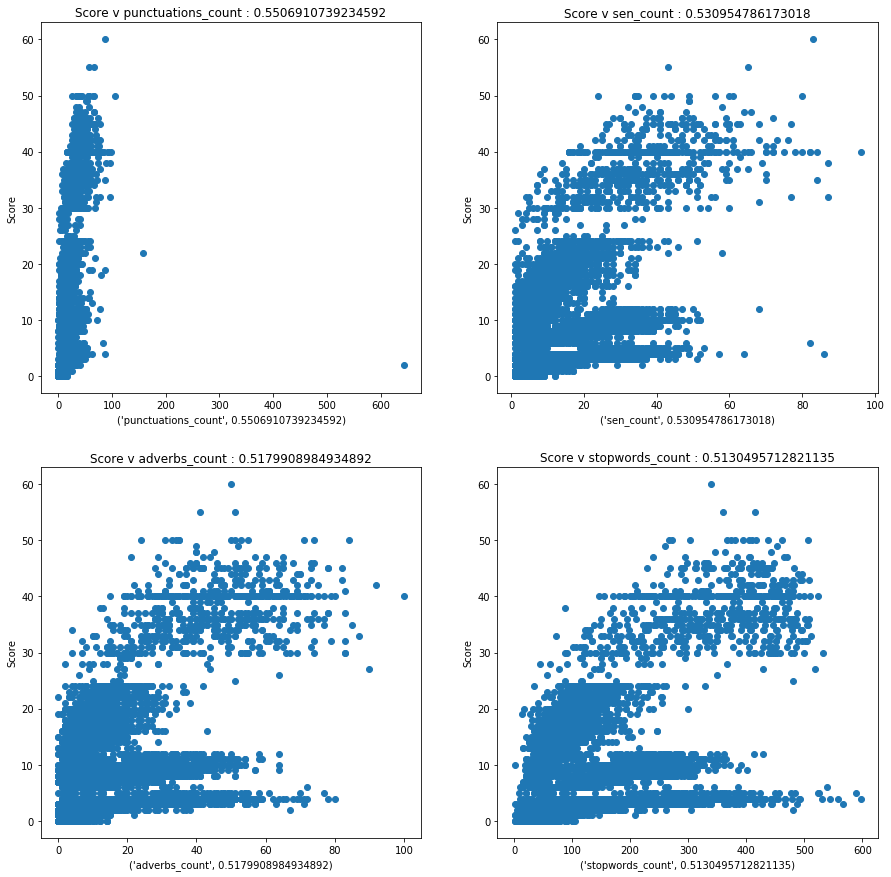

In [18]:
feature_kapps = []
for feature in all_feature_keys_list:
    if feature == sentences_key or feature == word_count_vector_key:
        continue
    np.random.seed(1)
    k_feat, _ = evaluate(X[[feature]+[sentences_key]], y)
    feature_kapps.append((feature, k_feat))
print()
feature_kapps.sort(key = lambda x:  -x[1])
for feature_kappa in feature_kapps:
    print(feature_kappa)
    

top_features = feature_kapps[:4]
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
axs = [ax1, ax2, ax3, ax4]
for i in range(len(top_features)):
    ax = axs[i]
    top_feature = top_features[i]
    ax.scatter(X[[top_feature[0]]],y)
    ax.set_ylabel('Score')
    ax.set_xlabel(top_feature)
    ax.set_title("Score v " + top_feature[0] + " : " + str(top_feature[1]))

fig.savefig('./figs/ScoreVFeature.png', bbox_inches = "tight")

### Content based features
Next we explored the addition of content based features using word2vec and similarity measures. Word2vec model was trained on the data and then used to get an average vector representation for each essay. Similarity measures were generated using 2 approaches. First we used LSA to calculate similairty between word vector representations of essays and paras of the required readings from their question prompts. We also computed the average word vectors for these paras and calculated thier similarity with the word vector representations of the prompts.

In [19]:
print("Evaluation using all features (All Essays)")

np.random.seed(1)
classifier = LinearRegression()
print("Model:", type(classifier).__name__)
k, _ = evaluate(X, y, classifier, wordvec=True)
print("Mean Quadratic Kappa Score:", k)
print()

Evaluation using all features (All Essays)
Model: LinearRegression
[ 3.431  mins ] Mean Quadratic Kappa Score: 0.9313253929131744



We also tried to tune the parameter of word vector size when evaluating on individual sets and a lower value seemed to work better.

In [20]:
for vec_size in [300, 100, 50, 30]:
    print("Number of features:", vec_size)
    for set_no in range(8):
        np.random.seed(1)
        X_set, y_set = X_sets[set_no], y_sets[set_no]
        classifier = LinearRegression()
        k, _ = evaluate(X_set, y_set, classifier, wordvec=True, num_features=vec_size)
        print("Mean Quadratic Kappa Score - Set", (set_no+1), ":", k)
    print()

Number of features: 300
[ 0.524  mins ] Mean Quadratic Kappa Score - Set 1 : 0.8169190944113428
[ 0.555  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6395043779402549
[ 0.231  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6038034641992887
[ 0.219  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7471464533852142
[ 0.254  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7705999828140432
[ 0.289  mins ] Mean Quadratic Kappa Score - Set 6 : 0.7638297176173998
[ 0.261  mins ] Mean Quadratic Kappa Score - Set 7 : 0.7617311810994153
[ 0.315  mins ] Mean Quadratic Kappa Score - Set 8 : 0.4977409291733522

Number of features: 100
[ 0.409  mins ] Mean Quadratic Kappa Score - Set 1 : 0.8414234374058122
[ 0.423  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6896942292416041
[ 0.157  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6280434878393428
[ 0.146  mins ] Mean Quadratic Kappa Score - Set 4 : 0.757701265390686
[ 0.185  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7920999603432669
[ 0.231  mins ] 

Next we tested the performance after using average word2vec representation and prompt similarity using LSA and word2vec.

In [33]:
for set_no in range(4):
    np.random.seed(1)
    X_set, y_set = X_sets[set_no+2], y_sets[set_no+2]  
#     for y in y_set.values.reshape(-1):
#         print(y, end=" ")
#     print()
    classifier = LinearRegression()
    k, _ = evaluate(X_set, y_set, classifier, wordvec=True, num_features=50, min_word_count=20, lsa=True, wordvec_sim=True)
    print("Mean Quadratic Kappa Score - Set", (set_no+3), ":", k)
print()

[ 1.728  mins ] Mean Quadratic Kappa Score - Set 3 : 0.6215040054984866
[ 2.031  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7406240116872083
[ 1.601  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7943593283547079
[ 2.553  mins ] Mean Quadratic Kappa Score - Set 6 : 0.7888913760696105



### Source dependent essay comparison
We evaluated the performance of the model on all the source dependent essays using only style based features and then along with the content based features.

In [36]:
X_src_dep_frames = [X_sets[2], X_sets[3], X_sets[4], X_sets[5]]
y_src_dep_frames = [y_sets[2], y_sets[3], y_sets[4], y_sets[5]]
X_src_dep = pd.concat(X_src_dep_frames)
y_src_dep = pd.concat(y_src_dep_frames)

classifier = LinearRegression()
k, _ = evaluate(X_src_dep, y_src_dep, classifier, wordvec=True, num_features=50, min_word_count=20, lsa=True, wordvec_sim=True)
print("Mean Quadratic Kappa Score (All Source Dependent):", k)
      
classifier = LinearRegression()
k, _ = evaluate(X_src_dep, y_src_dep, classifier)
print("Mean Quadratic Kappa Score (All Source Dependent - No Similarity):", k)

[ 8.975  mins ] Mean Quadratic Kappa Score (All Source Dependent): 0.7997313355839893
[ 0.001  mins ] Mean Quadratic Kappa Score (All Source Dependent - No Similarity): 0.7572657712396759


What we realized is that the sets 3 and 4 had a low range of grading scores (0 - 3). This was affecting their performance as in this lower range the corellation could be thrown off even if the rating was a little different. So we decided to try using random forest classifer on these sets to see if the performance improved. The idea was that random forest classifier is able to give us a more tighter fit than regression. We used all the 3 content based features 1) Average word2vec, 2) LSA similarity, 3) Average word2vec similarity. 
Random forest helped improve the performance for set 3 but not so much for set 4. Hence we decided to explore the reason behind this. When you see the distribution of scores alloted to different teams, for set 3 the scores are quite skewed. We suspect that this is the reason why regression was producing lower mean quadratic kappa score. For set 4, where the scores are more evenly distributed, we didn't notice any performance improvement.

In [37]:
for set_no in range(2):
    np.random.seed(1)
    X_set, y_set = X_sets[set_no+2], y_sets[set_no+2]
    classifier = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=5, random_state=1)
    k, _ = evaluate(X_set, y_set, classifier, wordvec=True, num_features=50, min_word_count=20, lsa=True, wordvec_sim=True)
    print("Mean Quadratic Kappa Score - Set", (set_no+3), ":", k)
print()

[ 2.074  mins ] Mean Quadratic Kappa Score - Set 3 : 0.7011079184585538
[ 2.263  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7369582001651515



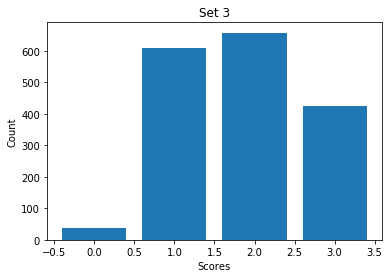

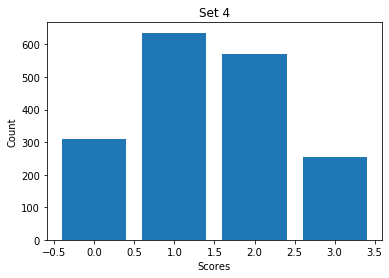

In [50]:
def analyze_score_distribution(scores, set_no):
    fig = plt.figure()
    scores = scores.values.reshape(-1)
    u_scores = dict(zip(list(scores),[list(scores).count(i) for i in list(scores)]))
    u_scores = [u_scores[0], u_scores[1], u_scores[2], u_scores[3]]
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.title("Set "+str(set_no))
    plt.bar([0, 1, 2, 3], u_scores)

analyze_score_distribution(y_sets[2], set_no=3)

analyze_score_distribution(y_sets[3], set_no=4)

In [52]:
for set_no in range(8):
    np.random.seed(1)
    X_set, y_set = X_sets[set_no], y_sets[set_no]
    classifier = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=5, random_state=1)
    k, _ = evaluate(X_set, y_set, classifier, wordvec=True, num_features=50, min_word_count=20)
    print("Mean Quadratic Kappa Score - Set", (set_no+1), ":", k)
print()

[ 0.668  mins ] Mean Quadratic Kappa Score - Set 1 : 0.8103838237836017
[ 0.685  mins ] Mean Quadratic Kappa Score - Set 2 : 0.6715365225685692
[ 0.372  mins ] Mean Quadratic Kappa Score - Set 3 : 0.706075686383768
[ 0.36  mins ] Mean Quadratic Kappa Score - Set 4 : 0.7411247208262871
[ 0.407  mins ] Mean Quadratic Kappa Score - Set 5 : 0.7985604439917602
[ 0.459  mins ] Mean Quadratic Kappa Score - Set 6 : 0.7370800540294848
[ 0.446  mins ] Mean Quadratic Kappa Score - Set 7 : 0.7318043597458342
[ 0.41  mins ] Mean Quadratic Kappa Score - Set 8 : 0.5498438155208698

